# Multitemporal data creation pipeline

In [2]:
from glob import glob
from natsort import natsorted
import os
from PIL import Image
import numpy as np
import tifffile as tiff
import torch
import time
from importlib import reload
import pandas as pd
import cv2 as cv

import unet_pipeline
import dataset_pipeline

from unet_pipeline import UNet
from dataset_pipeline import *

#reload(unet_pipeline)
reload(dataset_pipeline)

<module 'dataset_pipeline' from '/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data_creation/dataset_pipeline.py'>

In [3]:
DATA_PATH = "data_pipeline"
target_size = (128, 128) # W x H

#### 1 Find all images and reshape them

In [3]:
list_images = glob(os.path.join(DATA_PATH, "images", "*.tif"), recursive=True)
list_images = natsorted(list_images, key=lambda y: y.lower())

In [4]:
def reshape_data(input_image_path, output_image_dir, max_target_width = 1024, max_target_height = 1024):
    '''
    Reshapes images, so that non overlapping patches with a size of maximum 1024x1024 can be created. The discarded parts
    of the image are on the right side and at the bottom of the image.

    input_image_path: path of image to be reshaped
    output_image_dir: path to directory where reshaped images are to be stored
    '''
    input_image = Image.open(input_image_path)
    input_image = np.array(input_image)
    input_height = input_image.shape[0]
    input_width = input_image.shape[1]
    
    output_height = (input_height // max_target_height) * max_target_height
    output_width = (input_width // max_target_width) * max_target_width

    if output_height == input_height and output_width == input_width:
        print("Image {} is already reshaped: {}".format(os.path.basename(input_image_path),input_image.shape))
    else:
        print(f"Original image shape: {input_image.shape}")
        output_image = input_image[:output_height, :output_width, :]
        print(f"Transformed image shape: {output_image.shape}")
    
        save_path = os.path.join(output_image_dir, os.path.basename(input_image_path))
        tiff.imwrite(save_path, output_image)
        print("Saved transformed image tif file to: {}".format(save_path))

In [5]:
for i, image_path in enumerate(list_images):
    print(i, image_path)
    reshape_data(image_path, "data_pipeline/images")

0 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-720.tif


/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/models/UNet/.venvUNet/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (92274688 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Image 2023-09-27-Weimar-Deformation-Epoch6to7-720.tif is already reshaped: (8192, 11264, 3)
1 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-730.tif
Image 2023-09-27-Weimar-Deformation-Epoch6to7-730.tif is already reshaped: (8192, 11264, 3)
2 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-740.tif
Image 2023-09-27-Weimar-Deformation-Epoch6to7-740.tif is already reshaped: (8192, 11264, 3)
3 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-750.tif
Image 2023-09-27-Weimar-Deformation-Epoch6to7-750.tif is already reshaped: (8192, 11264, 3)
4 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-760.tif
Image 2023-09-27-Weimar-Deformation-Epoch6to7-760.tif is already reshaped: (8192, 11264, 3)
5 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-770.tif
Image 2023-09-27-Weimar-Deformation-Epoch6to7-770.tif is already reshaped: (8192, 11264, 3)
6 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-780.tif
Image 2023-09-27-Weima

#### 2 Create image patches

In [6]:
def split_image(image_path, DATA_PATH, target_size):
    '''
    Splits up the input image into patches of defined size.

    image_path: input image path
    DATA_PATH: path to data directory
    target_size: tuple with patch dimensions (W x H)
    '''
    
    target_width, target_height = target_size
    image=Image.open(image_path)
    image_width, image_height = image.size
    image_name = os.path.basename(image_path).split(".")[0]
    
    if image_width%target_width != 0 or image_height%target_height != 0:
        print("WARNING: Image {} is not transformed, current shape: {}".format(os.path.basename(image_path), image.size))
    else:
        tile_image_dir = os.path.join(DATA_PATH, "images_patches", "{}-{}x{}".format(image_name, target_width, target_height))
        if not os.path.isdir(tile_image_dir):
            os.mkdir(tile_image_dir)
        counter = 0
        counter_file_exist = 0
        for i in range (0, image_width, target_width):
            for j in range (0, image_height, target_height):
                box = (i, j, i+target_width, j+target_height)
                tile = image.crop(box)
                tile_filename = os.path.join(tile_image_dir, f'{image_name}-{target_width}x{target_height}-{i}_{j}.png')
                if not os.path.exists(tile_filename):
                    tile.save(tile_filename)
                    counter += 1
                else:
                    counter_file_exist += 1
                
        print(f"Created {counter} patches ({counter_file_exist} already exist) from {image_name}")
        print(f"Saved to: {tile_image_dir}")

In [7]:
for i, image_path in enumerate(list_images):
    print(i, image_path)
    split_image(image_path, DATA_PATH, target_size)

0 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-720.tif
Created 0 patches (5632 already exist) from 2023-09-27-Weimar-Deformation-Epoch6to7-720
Saved to: data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch6to7-720-128x128
1 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-730.tif
Created 0 patches (5632 already exist) from 2023-09-27-Weimar-Deformation-Epoch6to7-730
Saved to: data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch6to7-730-128x128
2 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-740.tif
Created 0 patches (5632 already exist) from 2023-09-27-Weimar-Deformation-Epoch6to7-740
Saved to: data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch6to7-740-128x128
3 data_pipeline/images/2023-09-27-Weimar-Deformation-Epoch6to7-750.tif
Created 0 patches (5632 already exist) from 2023-09-27-Weimar-Deformation-Epoch6to7-750
Saved to: data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch6to7-750-128x128


#### Create Predictions

In [8]:
def create_prediction_mask(model, image_patch_dir, DATA_PATH, threshold = 0.5):
    print(image_patch_dir)
    image_dataset = ImageDataset(image_patch_dir)
    start_time = time.time()
    prediction_list = []
    x=[]
    y=[]
    for i in range(len(image_dataset)):
        path = image_dataset.get_image_path(i)
        coordinates = os.path.basename(path).split("-")[-1].split(".")[0].split("_")
        x.append(coordinates[0])
        y.append(coordinates[1])

        image = image_dataset[i]
        image=image.unsqueeze(dim=0)
        prediction = model(image)
        prediction = (prediction > threshold).float()
        prediction = prediction.detach().squeeze().numpy().astype(np.uint8)
        prediction_list.append(prediction)

        #print("\r{}/{}".format(i+1, len(image_dataset)), end = '', flush = True)

    unique_values=set(x)
    len_x = len(unique_values)
    unique_values=set(y)
    len_y = len(unique_values)

    column_list = []
    for i in range(len_x):
        column = np.concatenate(prediction_list[i*len_y:(i+1)*len_y], axis=0)
        column_list.append(column)

    complete_prediction = np.concatenate(column_list, axis = 1)
    duration = time.time() - start_time
    print(f"\nDuration: {round(duration/60)} minutes")

    file_name = os.path.basename(image_patch_dir).split(".")[0] + "-prediction.tif"
    save_path = os.path.join(DATA_PATH, "targets", file_name)
    
    tiff.imwrite(save_path, complete_prediction)
    print("Saved segmentation mask tif file to: {}".format(save_path))

In [10]:
model_name = "model_nrepochs_213_sig_0-5.pth"
model = UNet(1)
model_checkpoint = os.path.join("Models", model_name)
checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu')) # remove map location in cluster
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


image_path = "data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-790-128x128"
#create_prediction_mask(model, image_path, DATA_PATH)

In [14]:
path_image_patches = os.path.join(DATA_PATH, "images_patches")
def list_directories(path):
    directories = []
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            directories.append(item_path)
    return directories
list_image_patches = list_directories(path_image_patches)
list_image_patches = natsorted(list_image_patches, key=lambda y: y.lower())

In [12]:
for i, image_patch_dir in enumerate(list_image_patches[1:]):
    print(i, image_patch_dir)
    #create_prediction_mask(model, image_patch_dir, DATA_PATH)

0 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch6to7-730-128x128
1 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch6to7-740-128x128
2 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch6to7-750-128x128
3 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch6to7-760-128x128
4 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch6to7-770-128x128
5 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch6to7-780-128x128
6 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-790-128x128
7 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-800-128x128
8 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-810-128x128
9 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-820-128x128
10 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-830-128x128
11 data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-840-128x128
12

#### Create target patches

In [65]:
def split_target(target_path, DATA_PATH, target_size):
    target_width, target_height = target_size
    target=Image.open(target_path)
    image_width, image_height = target.size
    target_name = os.path.basename(target_path).split(".")[0]

    if image_width%target_width != 0 or image_height%target_height != 0:
        print("WARNING: Target {} is not transformed, current shape: {}".format(os.path.basename(target_path), target.size))
    else:
        tile_image_dir = os.path.join(DATA_PATH, "targets_patches", "{}-{}x{}".format(target_name, target_width, target_height))
        if not os.path.isdir(tile_image_dir):
            os.mkdir(tile_image_dir)
        counter = 0
        counter_file_exist = 0
        for i in range (0, image_width, target_width):
            for j in range (0, image_height, target_height):
                box = (i, j, i+target_width, j+target_height)
                tile = target.crop(box)
                tile_filename = os.path.join(tile_image_dir, f'{target_name}-{target_width}x{target_height}-{i}_{j}.png')
                if not os.path.exists(tile_filename):
                    tile.save(tile_filename)
                    counter += 1
                else:
                    counter_file_exist += 1
                
        print(f"Created {counter} patches ({counter_file_exist} already exist) from {target_name}")
        print(f"Saved to: {tile_image_dir}")

In [66]:
list_targets = glob(os.path.join(DATA_PATH, "targets", "targets_after_open_cv", "*.tif"), recursive=True)
list_targets = natsorted(list_targets, key=lambda y: y.lower())


In [76]:

target_path = "data_pipeline/targets/clean_targets/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128-prediction.tif" 


split_target(target_path, DATA_PATH, target_size)

Created 5632 patches (0 already exist) from 2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128-prediction
Saved to: data_pipeline/targets_patches/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128-prediction-128x128


In [67]:
for i, target_path in enumerate(list_targets):
    print(i)
    split_target(target_path, DATA_PATH, target_size)

0


/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/models/UNet/.venvUNet/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (92274688 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Created 0 patches (5632 already exist) from 2023-09-27-Weimar-Deformation-Epoch6to7-720-128x128-prediction-128x128
Saved to: data_pipeline/targets_patches/2023-09-27-Weimar-Deformation-Epoch6to7-720-128x128-prediction-128x128-128x128
1
Created 0 patches (5632 already exist) from 2023-09-27-Weimar-Deformation-Epoch6to7-730-128x128-prediction-128x128
Saved to: data_pipeline/targets_patches/2023-09-27-Weimar-Deformation-Epoch6to7-730-128x128-prediction-128x128-128x128
2
Created 0 patches (5632 already exist) from 2023-09-27-Weimar-Deformation-Epoch6to7-740-128x128-prediction-128x128
Saved to: data_pipeline/targets_patches/2023-09-27-Weimar-Deformation-Epoch6to7-740-128x128-prediction-128x128-128x128
3
Created 0 patches (5632 already exist) from 2023-09-27-Weimar-Deformation-Epoch6to7-750-128x128-prediction-128x128
Saved to: data_pipeline/targets_patches/2023-09-27-Weimar-Deformation-Epoch6to7-750-128x128-prediction-128x128-128x128
4
Created 0 patches (5632 already exist) from 2023-09-27-W

#### Create dataframe for sanity check

In [4]:
def df_for_all_samples(root):
    images_paths = os.path.join(root,"images_patches")
    targets_paths = os.path.join(root, "targets_patches")

    list_images = glob(os.path.join(images_paths, "**", "*.png"), recursive=True)
    list_images = natsorted(list_images, key=lambda y: y.lower())
    list_targets = glob(os.path.join(targets_paths, "**", "*.png"), recursive=True)
    list_targets = natsorted(list_targets, key=lambda y: y.lower())

    pixel_count = []
    target = Image.open(list_targets[0])
    target_size = target.size
    for target_path in list_targets:
        target = Image.open(target_path)
        target = np.array(target)
        num_crack_pxls = np.sum(target)
        pixel_count.append(num_crack_pxls)
    contains_cracks = [0 if x == 0 else 1 for x in pixel_count]

    df = pd.DataFrame(zip(list_images, list_targets, contains_cracks, pixel_count),
                      columns = ["path_image", "path_target","crack", "num_pixels"])
    return df

In [5]:
df = df_for_all_samples(DATA_PATH)

In [6]:
num_top = 5
df_filtered = df[df["num_pixels"] != 0]
low_pixel_targets = df_filtered.nsmallest(num_top, 'num_pixels')
indices_bottom_10 = low_pixel_targets.index.tolist()
high_pixel_targets = df_filtered.nlargest(num_top, 'num_pixels')
indices_top_10 = high_pixel_targets.index.tolist()

In [7]:
high_pixel_targets

,path_image,path_target,crack,num_pixels
178373,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,4168
179334,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,4035
179462,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,3500
178823,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,3460
150213,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,3335


In [8]:
crack_dataset=CrackDataset(df["path_image"], df["path_target"])

data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128-7552_640.png
data_pipeline/targets_patches/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128-prediction-128x128-128x128/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128-prediction-128x128-128x128-7552_640.png


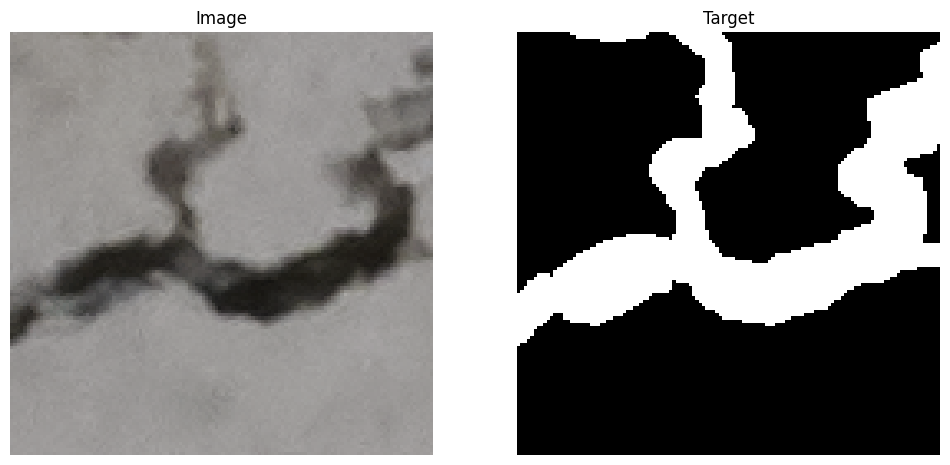

4168


In [9]:
a = []
for pic in indices_top_10:
    #print("Number of pixels: {}".format(df["num_pixels"][ass]))
    #print(ass, df["path_target"][ass])
    
    crack_dataset.visualize(pic) #323, 324, 773
    img = Image.open(crack_dataset.get_target_path(ass))
    img = np.array(img)
    print(img.sum())
    break
    
    

In [ ]:
kernel = np.ones((3,3),np.uint8)

In [48]:
image1 = cv.imread(path_image1, cv.IMREAD_GRAYSCALE)
image1_erosion = cv.erode(image1, np.ones((2,2),np.uint8), iterations = 1)
image1_ero_dila = cv.dilate(image1_erosion,kernel,iterations = 1)
image1_dilation = cv.dilate(image1,kernel,iterations = 1)
image1_closing = cv.morphologyEx(image1, cv.MORPH_CLOSE, kernel)
image1_opening = cv.morphologyEx(image1, cv.MORPH_OPEN, kernel)



img0_path = "data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-1000-128x128/2023-09-27-Weimar-Deformation-Epoch7to8-1000-128x128-7552_640.png"
img0 = Image.open(img0_path)


img1 = "data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128-8448_896.png"
img1 = Image.open(img1)

img2 = "data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-1010-128x128/2023-09-27-Weimar-Deformation-Epoch7to8-1010-128x128-2432_512.png"
img2 = Image.open(img2)

img3 = "data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-1000-128x128/2023-09-27-Weimar-Deformation-Epoch7to8-1000-128x128-9472_768.png"
img3 = Image.open(img3)

trgt0_path = "data_pipeline/Test_target1.png"
trgt0 = Image.open(trgt0_path)
trgt0_c2 = cv.imread(trgt0_path, cv.IMREAD_GRAYSCALE)
trgt0_dilation = cv.dilate(trgt0_c2,kernel,iterations = 1)
trgt0_closing = cv.morphologyEx(trgt0_c2, cv.MORPH_CLOSE, kernel)
trgt0_opening = cv.morphologyEx(trgt0_c2, cv.MORPH_OPEN, kernel)

trgt1_path = "data_pipeline/Test_target2.png"
trgt1 = Image.open(trgt1_path)
trgt1_c2 = cv.imread(trgt1_path, cv.IMREAD_GRAYSCALE)
trgt1_dilation = cv.dilate(trgt1_c2,kernel,iterations = 1)
trgt1_closing = cv.morphologyEx(trgt1_c2, cv.MORPH_CLOSE, kernel)
trgt1_opening = cv.morphologyEx(trgt1_c2, cv.MORPH_OPEN, kernel)

trgt2_path = "data_pipeline/Test_target3.png"
trgt2 = Image.open(trgt2_path)
trgt2_c2 = cv.imread(trgt2_path, cv.IMREAD_GRAYSCALE)
trgt2_dilation = cv.dilate(trgt2_c2,kernel,iterations = 1)
trgt2_closing = cv.morphologyEx(trgt2_c2, cv.MORPH_CLOSE, kernel)
trgt2_opening = cv.morphologyEx(trgt2_c2, cv.MORPH_OPEN, kernel)

trgt3_path = "data_pipeline/Test_target4.png"
trgt3 = Image.open(trgt3_path)
trgt3_c2 = cv.imread(trgt3_path, cv.IMREAD_GRAYSCALE)
trgt3_dilation = cv.dilate(trgt3_c2,kernel,iterations = 1)
trgt3_closing = cv.morphologyEx(trgt3_c2, cv.MORPH_CLOSE, kernel)
trgt3_opening = cv.morphologyEx(trgt3_c2, cv.MORPH_OPEN, kernel)


In [49]:
def configure_axis(ax,img,):
    ax.imshow(img, cmap = 'gray')
    ax.axis('off')

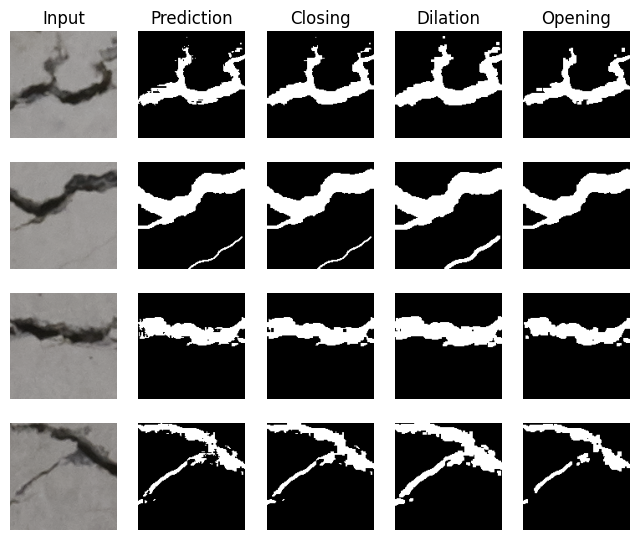

In [77]:
fig, axes = plt.subplots(4, 5, figsize=(8,6.5))
configure_axis(axes[0,0], img0)
axes[0,0].set_title('Input')
configure_axis(axes[0,1], trgt0)
axes[0,1].set_title('Prediction')
configure_axis(axes[0,2], trgt0_closing)
axes[0,2].set_title('Closing')
configure_axis(axes[0,3], trgt0_dilation)
axes[0,3].set_title('Dilation')
configure_axis(axes[0,4], trgt0_opening)
axes[0,4].set_title('Opening')


configure_axis(axes[1,0], img1)
configure_axis(axes[1,1], trgt1)
configure_axis(axes[1,2], trgt1_closing)
configure_axis(axes[1,3], trgt1_dilation)
configure_axis(axes[1,4], trgt1_opening)


configure_axis(axes[2,0], img2)
configure_axis(axes[2,1], trgt2)
configure_axis(axes[2,2], trgt2_closing)
configure_axis(axes[2,3], trgt2_dilation)
configure_axis(axes[2,4], trgt2_opening)

configure_axis(axes[3,0], img3)
configure_axis(axes[3,1], trgt3)
configure_axis(axes[3,2], trgt3_closing)
configure_axis(axes[3,3], trgt3_dilation)
configure_axis(axes[3,4], trgt3_opening)

plt.savefig("HEY")

#### OpenCV image modification

In [4]:
kernel = np.ones((3,3),np.uint8)

In [5]:
path_image1 = "data_pipeline/Test_target1.png"
trgt = Image.open(path_image1)
trgt = np.array(trgt)
trgt_sum = trgt.sum()
print(trgt_sum)
image1 = cv.imread(path_image1, cv.IMREAD_GRAYSCALE)
image1_erosion = cv.erode(image1, np.ones((2,2),np.uint8), iterations = 1)
image1_ero_dila = cv.dilate(image1_erosion,kernel,iterations = 1)
image1_dilation = cv.dilate(image1,kernel,iterations = 1)
image1_closing = cv.morphologyEx(image1, cv.MORPH_CLOSE, kernel)
image1_opening = cv.morphologyEx(image1, cv.MORPH_OPEN, kernel)

path_image2 = "data_pipeline/Test_target2.png"
image2 = cv.imread(path_image2, cv.IMREAD_GRAYSCALE)
image2_erosion = cv.erode(image2, np.ones((2,2),np.uint8), iterations = 1)
image2_ero_dila = cv.dilate(image2_erosion,kernel,iterations = 1)
image2_dilation = cv.dilate(image2,kernel,iterations = 1)
image2_closing = cv.morphologyEx(image2, cv.MORPH_CLOSE, kernel)
image2_opening = cv.morphologyEx(image2, cv.MORPH_OPEN, kernel)

path_image3 = "data_pipeline/Test_target3.png"
image3 = cv.imread(path_image3, cv.IMREAD_GRAYSCALE)
print(image3.shape)
image3_erosion = cv.erode(image3, np.ones((2,2),np.uint8), iterations = 1)
image3_ero_dila = cv.dilate(image3_erosion,kernel,iterations = 1)
image3_dilation = cv.dilate(image3,kernel,iterations = 1)
image3_closing = cv.morphologyEx(image3, cv.MORPH_CLOSE, kernel)
image3_opening = cv.morphologyEx(image3, cv.MORPH_OPEN, kernel)

path_image4 = "data_pipeline/Test_target4.png"
image4 = cv.imread(path_image4, cv.IMREAD_GRAYSCALE)
image4_erosion = cv.erode(image4, np.ones((2,2),np.uint8), iterations = 1)
image4_ero_dila = cv.dilate(image4_erosion,kernel,iterations = 1)
image4_dilation = cv.dilate(image4,kernel,iterations = 1)
image4_closing = cv.morphologyEx(image4, cv.MORPH_CLOSE, kernel)
image4_opening = cv.morphologyEx(image4, cv.MORPH_OPEN, kernel)

2741
(128, 128)


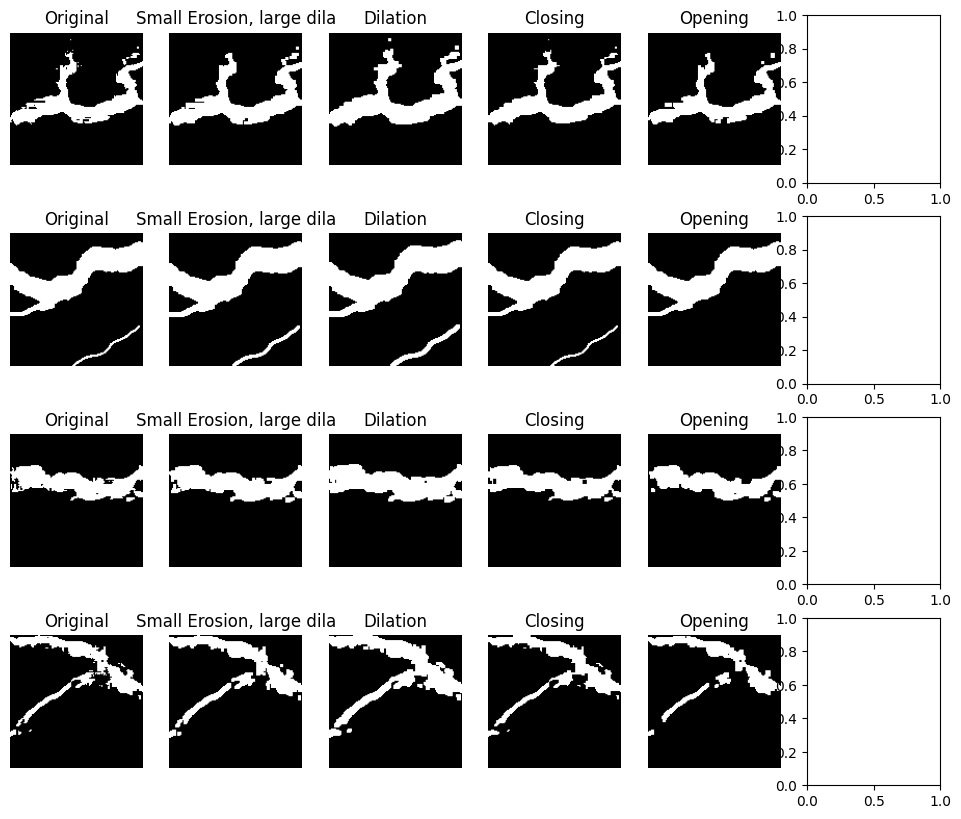

In [47]:
fig, axes = plt.subplots(4, 6, figsize=(12,10))
axes[0, 0].imshow(image1, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')
axes[0, 1].imshow(image1_ero_dila, cmap='gray')
axes[0, 1].set_title('Small Erosion, large dila')
axes[0, 1].axis('off')
axes[0, 2].imshow(image1_dilation, cmap='gray')
axes[0, 2].set_title('Dilation')
axes[0, 2].axis('off')
axes[0, 3].imshow(image1_closing, cmap='gray')
axes[0, 3].set_title('Closing')
axes[0, 3].axis('off')
axes[0, 4].imshow(image1_opening, cmap='gray')
axes[0, 4].set_title('Opening')
axes[0, 4].axis('off')

axes[1, 0].imshow(image2, cmap='gray')
axes[1, 0].set_title('Original')
axes[1, 0].axis('off')
axes[1, 1].imshow(image2_ero_dila, cmap='gray')
axes[1, 1].set_title('Small Erosion, large dila')
axes[1, 1].axis('off')
axes[1, 2].imshow(image2_dilation, cmap='gray')
axes[1, 2].set_title('Dilation')
axes[1, 2].axis('off')
axes[1, 3].imshow(image2_closing, cmap='gray')
axes[1, 3].set_title('Closing')
axes[1, 3].axis('off')
axes[1, 4].imshow(image2_opening, cmap='gray')
axes[1, 4].set_title('Opening')
axes[1, 4].axis('off')

axes[2, 0].imshow(image3, cmap='gray')
axes[2, 0].set_title('Original')
axes[2, 0].axis('off')
axes[2, 1].imshow(image3_ero_dila, cmap='gray')
axes[2, 1].set_title('Small Erosion, large dila')
axes[2, 1].axis('off')
axes[2, 2].imshow(image3_dilation, cmap='gray')
axes[2, 2].set_title('Dilation')
axes[2, 2].axis('off')
axes[2, 3].imshow(image3_closing, cmap='gray')
axes[2, 3].set_title('Closing')
axes[2, 3].axis('off')
axes[2, 4].imshow(image3_opening, cmap='gray')
axes[2, 4].set_title('Opening')
axes[2, 4].axis('off')

axes[3, 0].imshow(image4, cmap='gray')
axes[3, 0].set_title('Original')
axes[3, 0].axis('off')
axes[3, 1].imshow(image4_ero_dila, cmap='gray')
axes[3, 1].set_title('Small Erosion, large dila')
axes[3, 1].axis('off')
axes[3, 2].imshow(image4_dilation, cmap='gray')
axes[3, 2].set_title('Dilation')
axes[3, 2].axis('off')
axes[3, 3].imshow(image4_closing, cmap='gray')
axes[3, 3].set_title('Closing')
axes[3, 3].axis('off')
axes[3, 4].imshow(image4_opening, cmap='gray')
axes[3, 4].set_title('Opening')
axes[3, 4].axis('off')
plt.show()

In [179]:
path_big_image = "data_pipeline/targets/clean_targets/2023-09-27-Weimar-Deformation-Epoch7to8-1000-128x128-prediction.tif"
kernel = np.ones((3,3),np.uint8)


In [180]:
big_image = cv.imread(path_big_image, cv.IMREAD_GRAYSCALE)
big_image_closing = cv.morphologyEx(big_image, cv.MORPH_CLOSE, kernel)
tiff.imwrite("test_closing_target_1000.tif", big_image_closing)

#### Clean Patches

In [63]:
def clean_dataset(df, pixel_threshold = 5):
    low_pixel_targets_df = df[(df["num_pixels"] <= pixel_threshold) & (df["num_pixels"]>0)]
    for index, row in low_pixel_targets_df.iterrows():
        target = Image.open(row["path_target"])
        size = target.size
        target = np.array(target)
        target = np.zeros((size[1], size[0]), dtype = np.uint8)
        target_image = Image.fromarray(target)
        target_image.save(row["path_target"])
    if low_pixel_targets_df.empty:
        print("No annotations with less than {} pixels in the dataset.".format(pixel_threshold+1))
    else:
        print(low_pixel_targets_df)
        print("Removed annotations in {} targets.".format(len(low_pixel_targets_df)))

In [64]:
clean_dataset(df, pixel_threshold = 4)

                                               path_image  \
91277   data_pipeline/images_patches/2023-09-27-Weimar...   
91437   data_pipeline/images_patches/2023-09-27-Weimar...   
92067   data_pipeline/images_patches/2023-09-27-Weimar...   
92185   data_pipeline/images_patches/2023-09-27-Weimar...   
92225   data_pipeline/images_patches/2023-09-27-Weimar...   
92241   data_pipeline/images_patches/2023-09-27-Weimar...   
92418   data_pipeline/images_patches/2023-09-27-Weimar...   
92627   data_pipeline/images_patches/2023-09-27-Weimar...   
92633   data_pipeline/images_patches/2023-09-27-Weimar...   
92883   data_pipeline/images_patches/2023-09-27-Weimar...   
93019   data_pipeline/images_patches/2023-09-27-Weimar...   
93072   data_pipeline/images_patches/2023-09-27-Weimar...   
93141   data_pipeline/images_patches/2023-09-27-Weimar...   
93200   data_pipeline/images_patches/2023-09-27-Weimar...   
93481   data_pipeline/images_patches/2023-09-27-Weimar...   
93535   data_pipeline/im

In [17]:
df = df_for_all_samples(DATA_PATH)
num_top = 30
df_filtered = df[df["num_pixels"] != 0]
low_pixel_targets = df_filtered.nsmallest(num_top, 'num_pixels')
indices_bottom_10 = low_pixel_targets.index.tolist()
high_pixel_targets = df_filtered.nlargest(num_top, 'num_pixels')
indices_top_10 = high_pixel_targets.index.tolist()

In [18]:
low_pixel_targets

,path_image,path_target,crack,num_pixels
1876,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,5
2272,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,5
2396,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,5
2565,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,5
3144,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,5
3228,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,5
3304,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,5
3357,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,5
3358,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,5
3788,data_pipeline/images_patches/2023-09-27-Weimar...,data_pipeline/targets_patches/2023-09-27-Weima...,1,5


#### Recreate big images

In [45]:
def create_target_from_patches(patch_dir):
    x=[]
    y=[]
    path_target_list = glob(os.path.join(patch_dir, "*.png"), recursive=True)
    path_target_list = natsorted(path_target_list, key=lambda y: y.lower())
    targets = []
    for path in path_target_list:
        coordinates = path.split("-")[-1]
        coordinates = coordinates.split(".")[0]
        coordinates = coordinates.split("_")
        
        x.append(coordinates[0])
        y.append(coordinates[1])
        
        target = Image.open(path)
        target = np.array(target, dtype = np.uint8)
        targets.append(target)

    unique_values=set(x)
    len_x = len(unique_values)
    unique_values=set(y)
    len_y = len(unique_values)
    column_list = []
    
    for i in range(len_x):
        
        column = np.concatenate(targets[i*len_y:(i+1)*len_y], axis=0)
        column_list.append(column)
    
    new_target = np.concatenate(column_list, axis = 1)
    file_name = os.path.basename(patch_dir) + ".tif"
    save_path = os.path.join("data_pipeline", "targets", "targets_for_open_cv", file_name)
    tiff.imwrite(save_path, new_target)
    print("Saved clean target tif file to: {}".format(save_path))




In [46]:
path_target_patches = os.path.join(DATA_PATH, "targets_patches")
def list_directories(path):
    directories = []
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            directories.append(item_path)
    return directories
list_target_patches = list_directories(path_target_patches)
list_target_patches = natsorted(list_target_patches, key=lambda y: y.lower())

In [47]:
for i, dir in enumerate(list_target_patches):
    
    create_target_from_patches(dir)

Saved clean target tif file to: data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-720-128x128-prediction-128x128.tif
Saved clean target tif file to: data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-730-128x128-prediction-128x128.tif
Saved clean target tif file to: data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-740-128x128-prediction-128x128.tif
Saved clean target tif file to: data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-750-128x128-prediction-128x128.tif
Saved clean target tif file to: data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-760-128x128-prediction-128x128.tif
Saved clean target tif file to: data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-770-128x128-prediction-128x128.tif
Saved clean target tif file to: data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Ep

#### Perform OpenCV on new big images

Careful to touch images of epoch 890, 970, 1026

The 790 one is tricky

In [48]:
list_targets = glob(os.path.join(DATA_PATH, "targets", "targets_for_open_cv", "*.tif"), recursive=True)
list_targets = natsorted(list_targets, key=lambda y: y.lower())
list_targets.pop(31) #1026
list_targets.pop(25) #970
list_targets.pop(17) #890
for i, lol in enumerate(list_targets):
    print(i, lol)

0 data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-720-128x128-prediction-128x128.tif
1 data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-730-128x128-prediction-128x128.tif
2 data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-740-128x128-prediction-128x128.tif
3 data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-750-128x128-prediction-128x128.tif
4 data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-760-128x128-prediction-128x128.tif
5 data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-770-128x128-prediction-128x128.tif
6 data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-780-128x128-prediction-128x128.tif
7 data_pipeline/targets/targets_for_open_cv/2023-09-27-Weimar-Deformation-Epoch7to8-790-128x128-prediction-128x128.tif
8 data_pipeline/targets/targets_for_open_cv/2023

In [49]:
kernel = np.ones((3,3),np.uint8)
for i, target_path in enumerate(list_targets):
    big_image = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)
    big_image_closing = cv2.morphologyEx(big_image, cv2.MORPH_CLOSE, kernel)
    file_name = os.path.basename(target_path)
    save_path = os.path.join(DATA_PATH, "targets", "targets_after_open_cv", file_name)
    tiff.imwrite(save_path, big_image_closing)
    print("{} Saved OpenCV target to {}".format(i, save_path))

0 Saved OpenCV target to data_pipeline/targets/targets_after_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-720-128x128-prediction-128x128.tif
1 Saved OpenCV target to data_pipeline/targets/targets_after_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-730-128x128-prediction-128x128.tif
2 Saved OpenCV target to data_pipeline/targets/targets_after_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-740-128x128-prediction-128x128.tif
3 Saved OpenCV target to data_pipeline/targets/targets_after_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-750-128x128-prediction-128x128.tif
4 Saved OpenCV target to data_pipeline/targets/targets_after_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-760-128x128-prediction-128x128.tif
5 Saved OpenCV target to data_pipeline/targets/targets_after_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-770-128x128-prediction-128x128.tif
6 Saved OpenCV target to data_pipeline/targets/targets_after_open_cv/2023-09-27-Weimar-Deformation-Epoch6to7-780-128x128-prediction-128x

#### Rename manually annotated targets

In [28]:

dir1 = "data_pipeline/targets_patches/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128-prediction-128x128/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128-prediction-128x128-0_0.png"
dir2 = '/path/to/directory2'

# Function to extract parts from filenames
def extract_parts(filename):
    parts = filename.replace('.png', '').split('-')
    return parts

In [81]:
dir_path = "data_pipeline/targets_patches/2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-128x128"

In [82]:
# Iterate through the files in Directory 2
for filename in os.listdir(dir_path):
    if filename.endswith('.png'):
        print(filename)
        # Extract parts from the current filename
        parts = extract_parts(filename)
        separator = "-"
        part1 = separator.join(parts[:-1])
        part2 = part1 + "-128x128-"
        part3 = part2 + parts[-1] + ".png"

        old_filepath = os.path.join(dir_path, filename)
        new_filepath = os.path.join(dir_path, part3)
        
        
        os.rename(old_filepath, new_filepath)
        #print(f"Renamed: {old_filepath} -> {new_filepath}")

print("Renaming completed.")

2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-10112_6272.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-4480_3712.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-10752_7296.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-7552_4608.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-9216_1024.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-3968_6400.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-384_6144.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-9344_4352.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-9856_3968.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-1920_3968.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-128x128-512_5504.png
2023-09-27-Weimar-Deformation-Epoch7to8-890-128x128-prediction-12

#### Create multitemporal data

In [19]:
def get_images_paths(root):
    images_parent_dir = os.path.join(root, "images_patches")
    targets_parent_dir = os.path.join(root, "targets_patches")

    images_paths = [] # save sorted image dir paths (sorted by epoch)
    targets_paths = []
    patches_per_image = [] # list with lists per image
    patches_per_target = []
    
    for image_dir in os.listdir(images_parent_dir):
        path = os.path.join(images_parent_dir, image_dir)
        if not path.endswith(".DS_Store"):
            #code = int(x.split('-')[-2]
            images_paths.append(path)
    
    images_paths = sorted(images_paths, key=lambda x: int(x.split('-')[-2]))
    for image_path in images_paths:
        list_images = glob(os.path.join(image_path, "*.png"), recursive=True)
        list_images = natsorted(list_images, key=lambda y: y.lower())
        patches_per_image.append(list_images)

    for target_dir in os.listdir(targets_parent_dir):
        path = os.path.join(targets_parent_dir, target_dir)
        if not path.endswith(".DS_Store"):
            targets_paths.append(path)

    targets_paths = sorted(targets_paths, key=lambda x: int(x.split('-')[-5]))
    for target_path in targets_paths:
        list_targets = glob(os.path.join(target_path, "*.png"), recursive=True)
        list_targets = natsorted(list_targets, key=lambda y: y.lower())
        patches_per_target.append(list_targets)
        
    return patches_per_image, patches_per_target

def stack_images(patches_per_image, repeat_list, mt_image_dir):
    counter = 0
    for i in range(len(patches_per_image[0])):
        stacked_image_paths = []
        stacked_images = []
        coordinates = []
        for j in range(7, len(patches_per_image)): # 7 because there are 7 images from epoch 6-7
            stacked_image_paths.append(patches_per_image[j][i])
            if j in repeat_list:
                stacked_image_paths.append(patches_per_image[j][i])
        for image_path in stacked_image_paths:
            coordinates = image_path.split(".")[0].split("-")[-1]
            coordinates = coordinates.split("_")
            if not all(coordinate.isdigit() for coordinate in coordinates):
                raise ValueError("Error: Naming scheme wrong, coordinates of images are not digits.")
            image = Image.open(image_path)
            image = np.array(image)/255.0
            stacked_images.append(image)
        mt_image = np.stack(stacked_images, axis=0)
        save_path = os.path.join(mt_image_dir,
                                 "mt_image_{}_{}".format(coordinates[0], coordinates[1]))
        np.save(save_path, mt_image)
        counter += 1
    print("Saved {} multi-temporal images to '{}'.".format(counter, mt_image_dir)) 

def stack_targets(patches_per_target, repeat_list, mt_target_dir):
    counter = 0
    for i in range(len(patches_per_target[0])):
        stacked_target_paths = []
        stacked_targets = []
        coordinates = []
        for j in range(7, len(patches_per_target)):
            stacked_target_paths.append(patches_per_target[j][i])
            if j in repeat_list:
                stacked_target_paths.append(patches_per_target[j][i])
        for target_path in stacked_target_paths:
            coordinates = target_path.split(".")[0].split("-")[-1]
            coordinates = coordinates.split("_")
            if not all(coordinate.isdigit() for coordinate in coordinates):
                raise ValueError("Error: Naming scheme wrong, coordinates of targets are not digits.")
            target = Image.open(target_path)
            target = np.array(target)
            target = np.expand_dims(target, axis=-1)
            stacked_targets.append(target)
        mt_target = np.stack(stacked_targets, axis=0)
        save_path = os.path.join(mt_target_dir,
                                 "mt_targets_{}_{}".format(coordinates[0], coordinates[1]))
        np.save(save_path, mt_target)
        counter += 1
    print("Saved {} multi-temporal targets to '{}'.".format(counter, mt_target_dir)) 

def create_multitemporal_data(root):

    patches_per_image, patches_per_target = get_images_paths(root)

    mt_dir = os.path.join(root, "multi-temporal_data_only_7-8")
    mt_image_dir = os.path.join(mt_dir, "mt-images")
    mt_target_dir = os.path.join(mt_dir, "mt-targets")
    if not os.path.exists(mt_dir):
        os.mkdir(mt_dir)
        os.mkdir(mt_image_dir)
        os.mkdir(mt_target_dir)
        print(f"Created multi-temporal data directory in '{mt_dir}'.")  

    repeat_list = [7, 11, 15, 19, 23, 26, 31] # images 15, 26 and 31 are manually annotated, others are evenly
    # spaced between the manual annotated ones
    
    if not all(len(sublist) == len(patches_per_image[0]) for sublist in patches_per_image):
        raise ValueError("Error: Missing multitemporal data for images.")
    stack_images(patches_per_image, repeat_list, mt_image_dir)
    
    
    if not all(len(sublist) == len(patches_per_target[0]) for sublist in patches_per_target):
        raise ValueError("Error: Missing multitemporal data for targts.")
    stack_targets(patches_per_target, repeat_list, mt_target_dir)
    


In [15]:
create_multitemporal_data(DATA_PATH)

Created multi-temporal data directory in 'data_pipeline/multi-temporal_data_only_7-8'.
Saved 5632 multi-temporal images to 'data_pipeline/multi-temporal_data_only_7-8/mt-images'.
Saved 5632 multi-temporal targets to 'data_pipeline/multi-temporal_data_only_7-8/mt-targets'.


In [16]:
list_mt_images = glob(os.path.join(DATA_PATH, "multi-temporal_data_only_7-8", "mt-images", "*.npy"), recursive=True)
list_mt_images = natsorted(list_mt_images, key=lambda y: y.lower())

list_mt_targets = glob(os.path.join(DATA_PATH, "multi-temporal_data_only_7-8", "mt-targets", "*.npy"), recursive=True)
list_mt_targets = natsorted(list_mt_targets, key=lambda y: y.lower())

In [17]:
mt_dataset = MtCrackDataset(list_mt_images, list_mt_targets)
print(len(mt_dataset))

5632


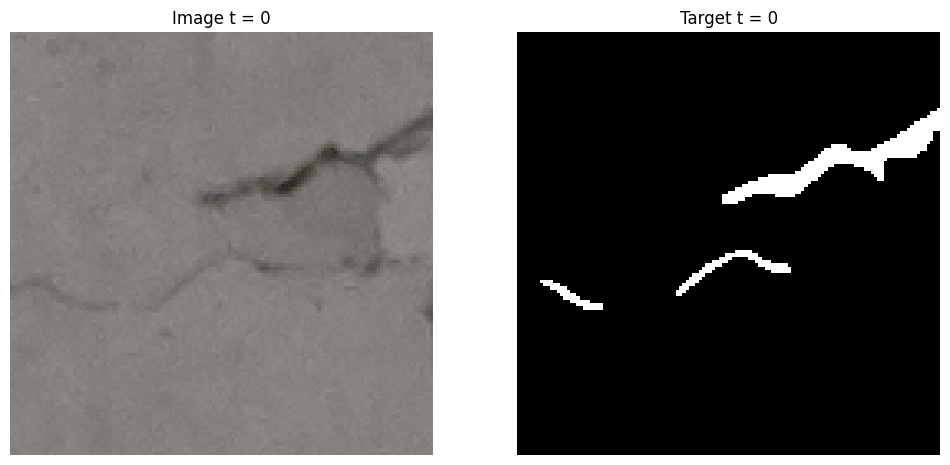

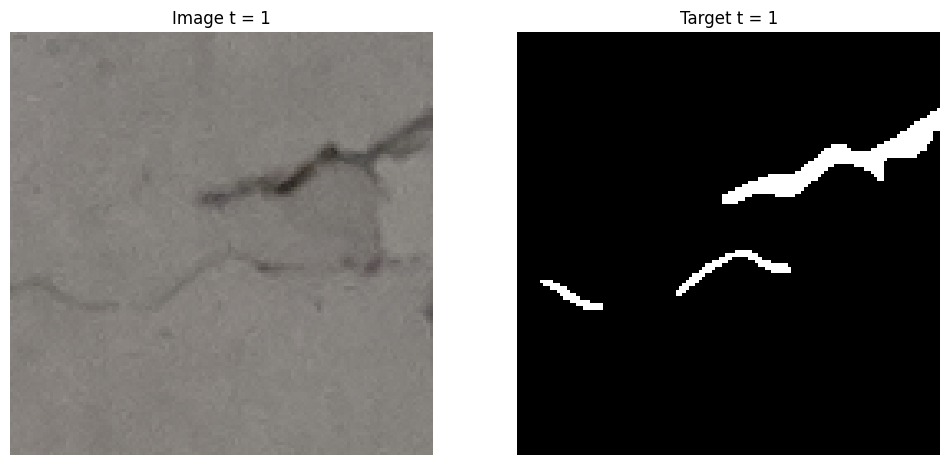

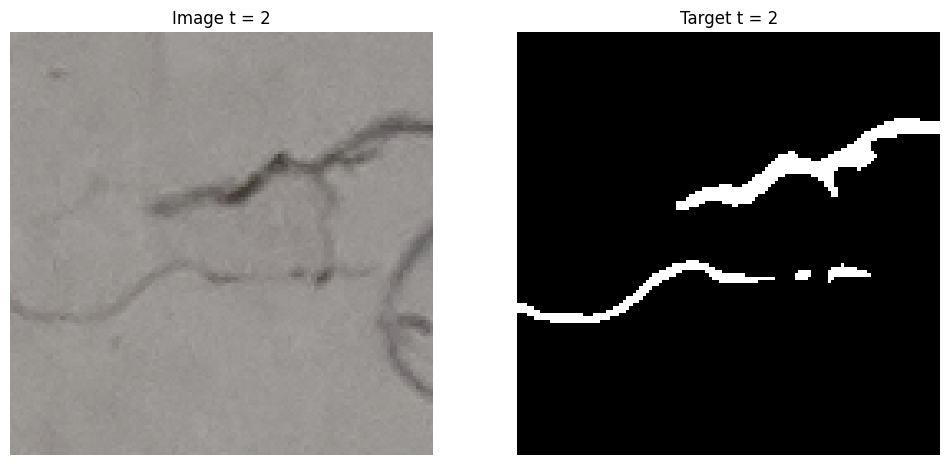

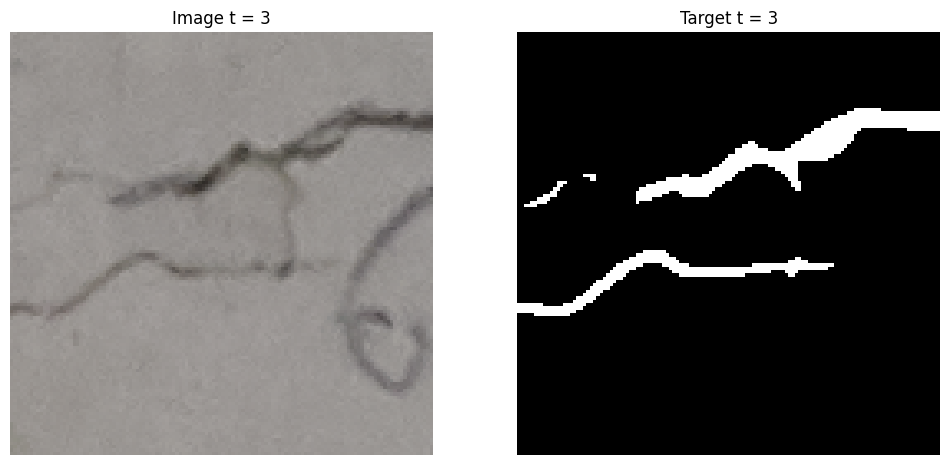

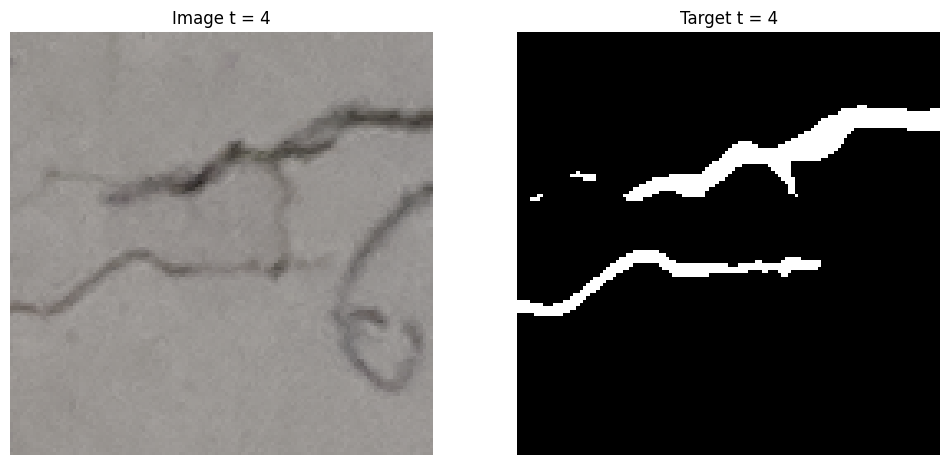

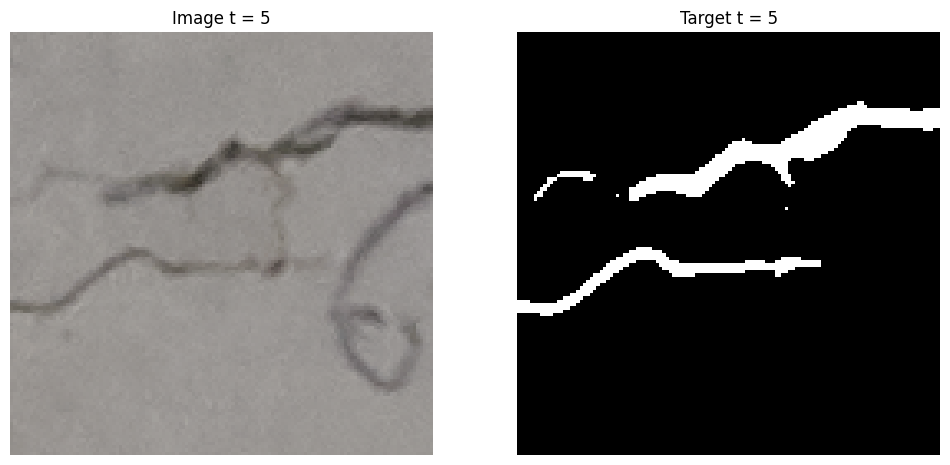

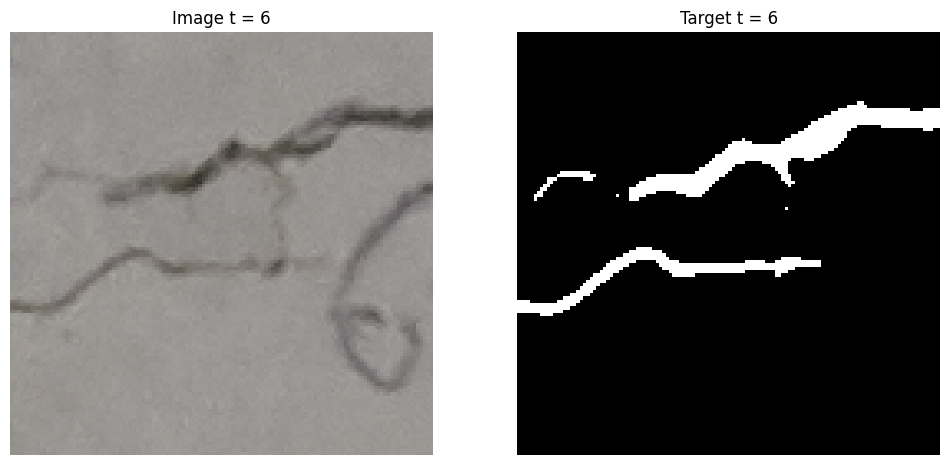

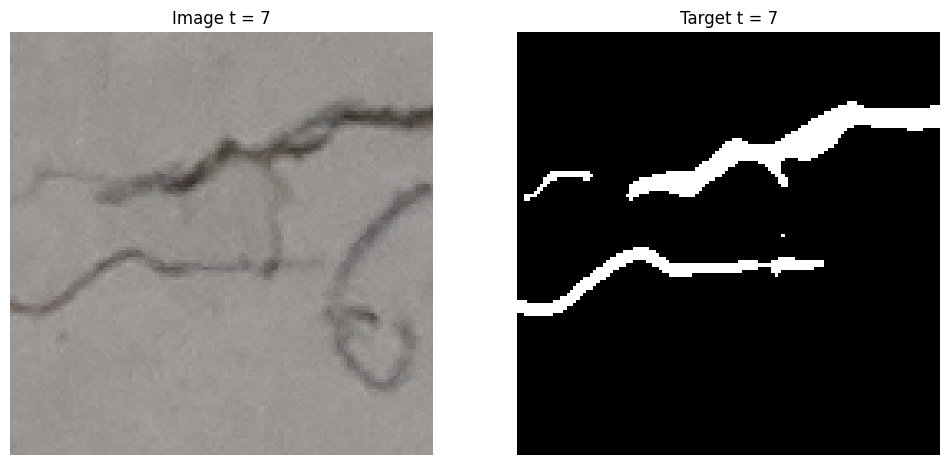

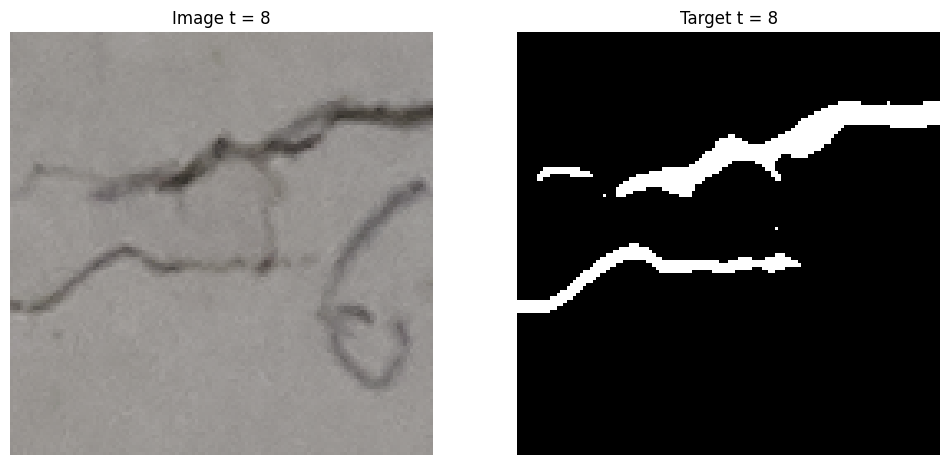

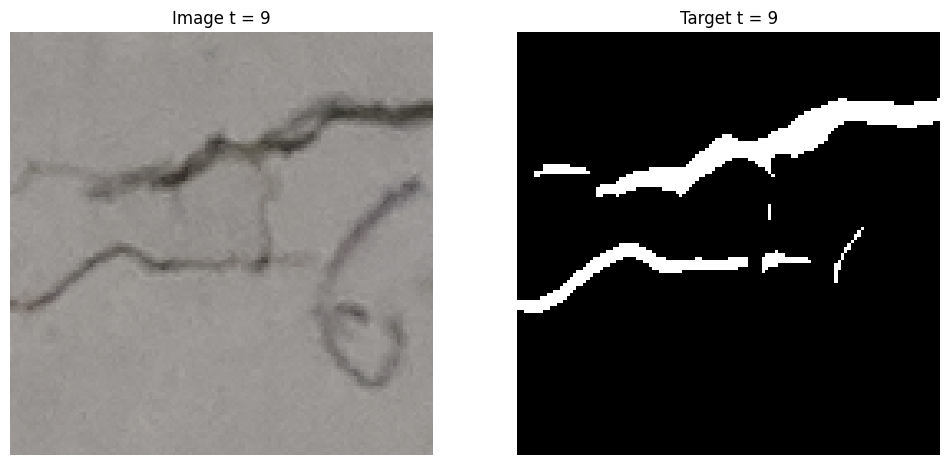

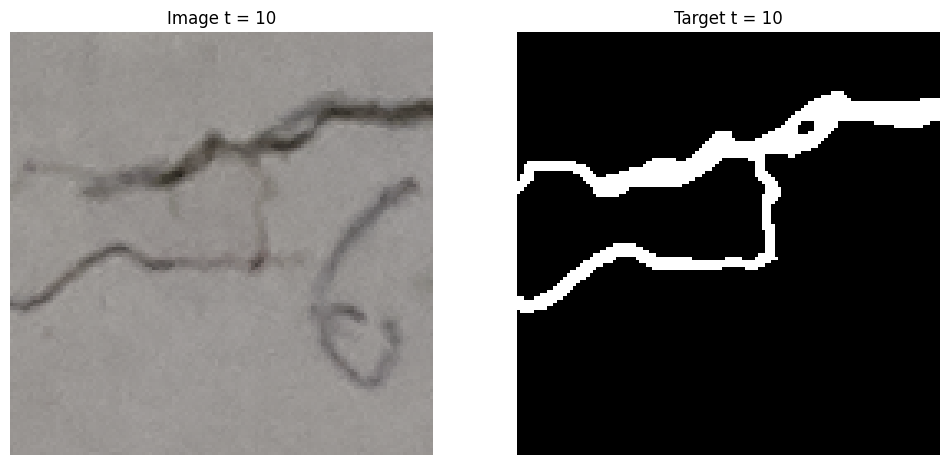

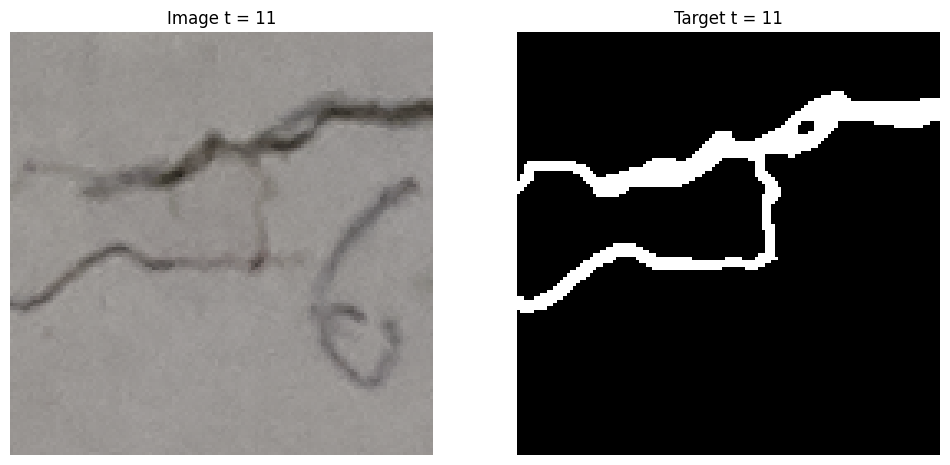

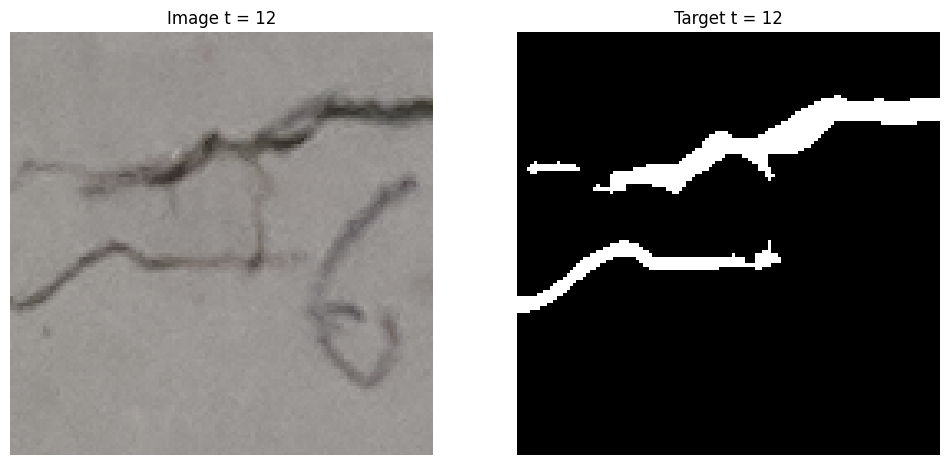

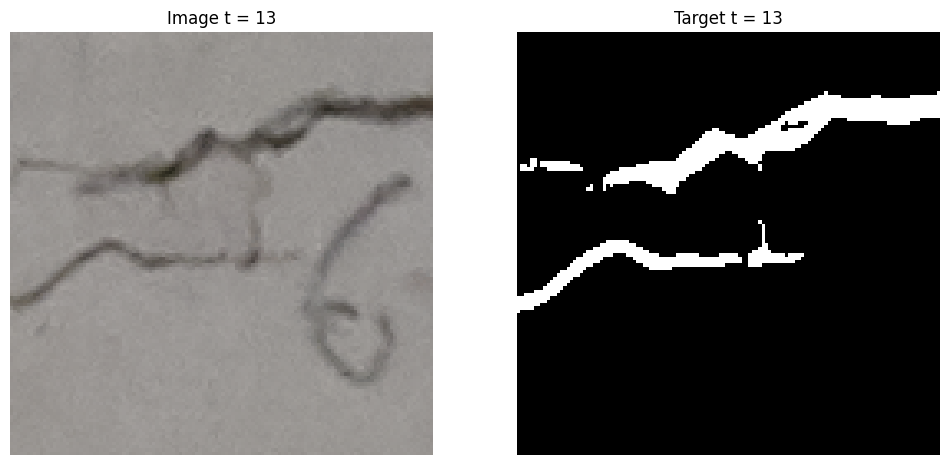

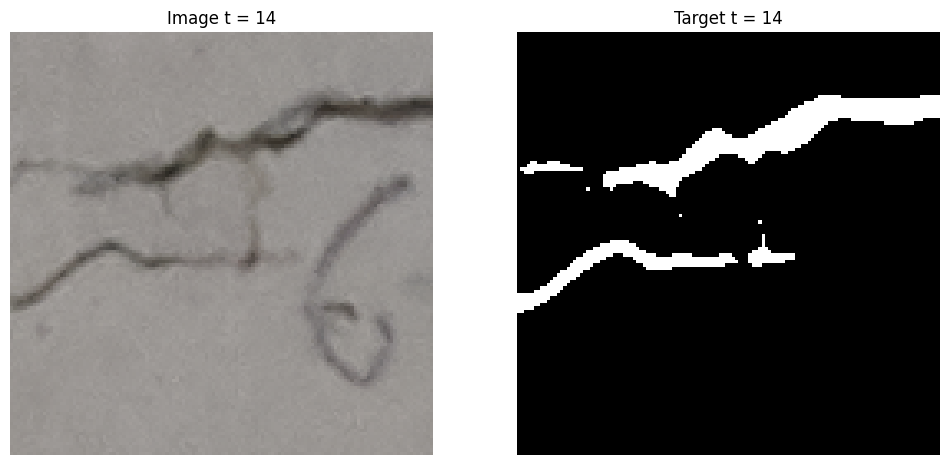

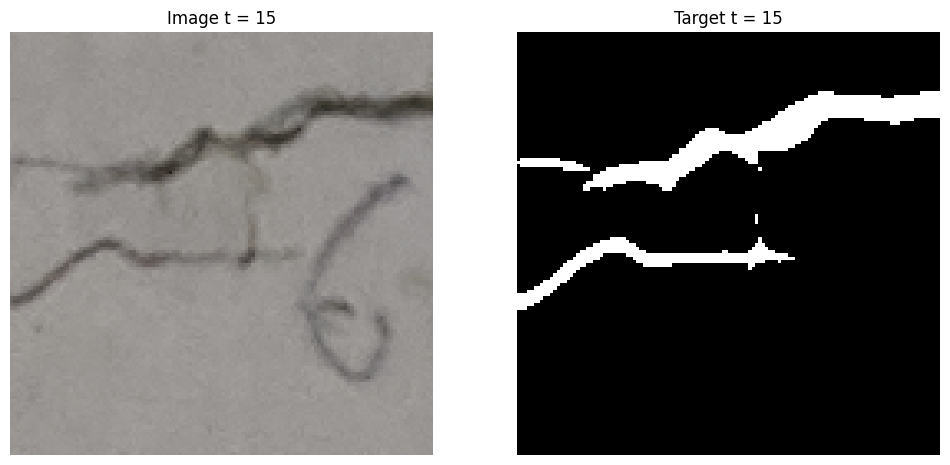

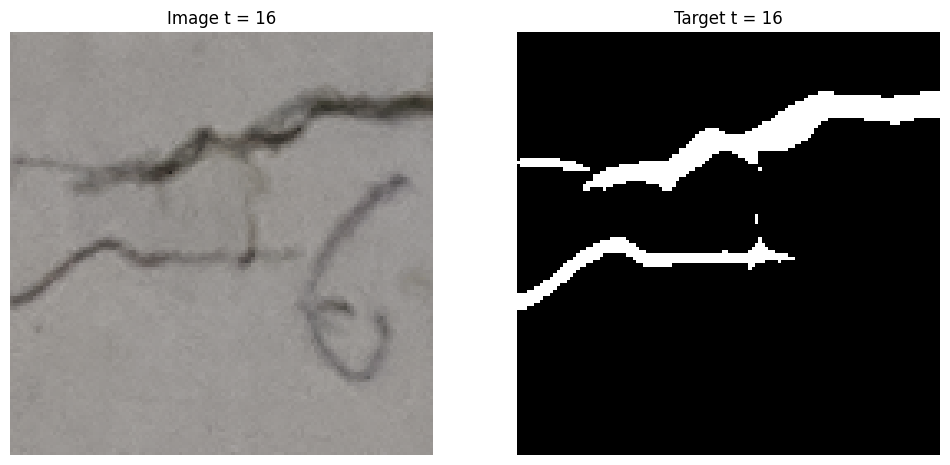

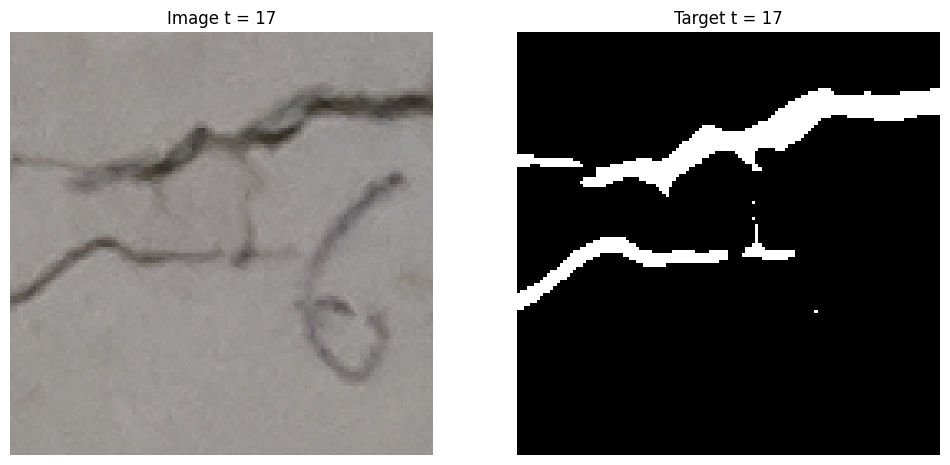

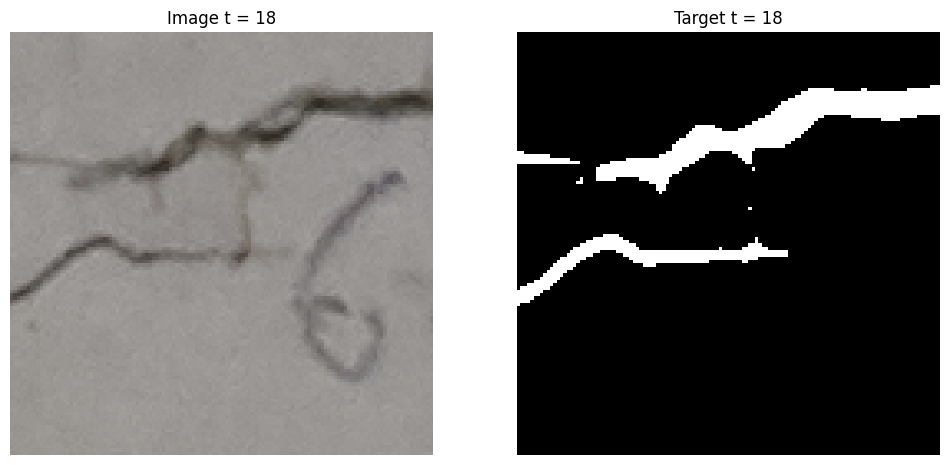

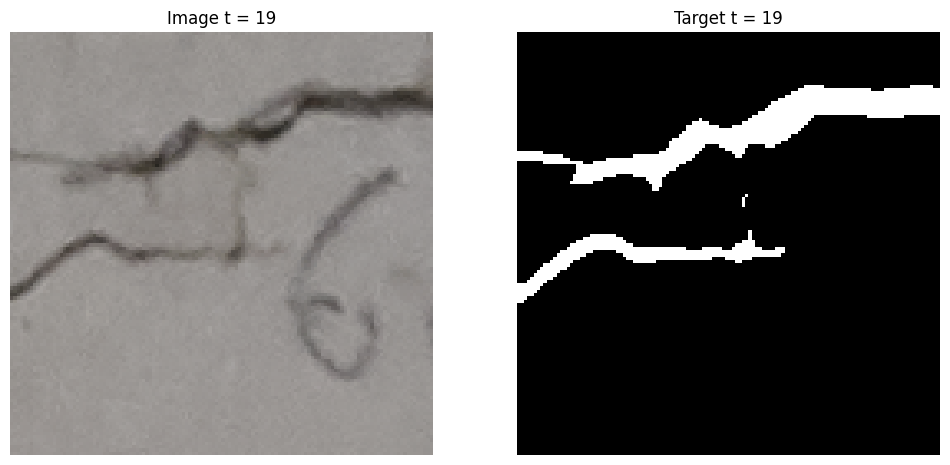

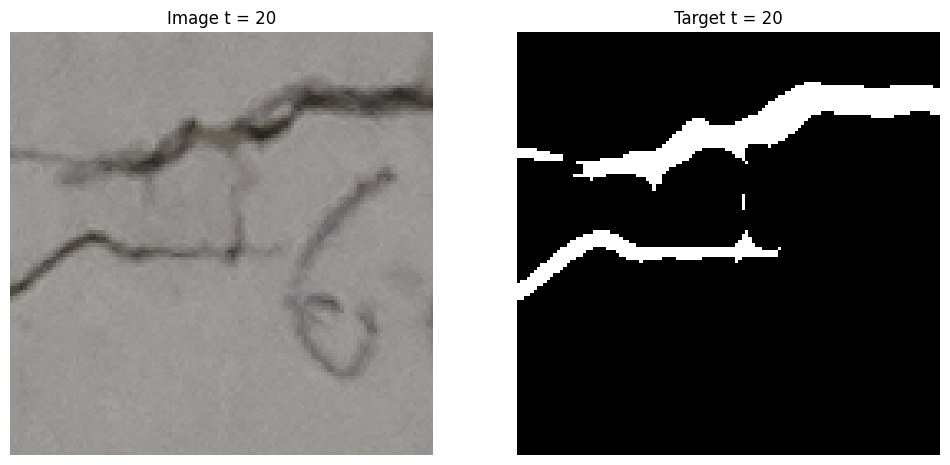

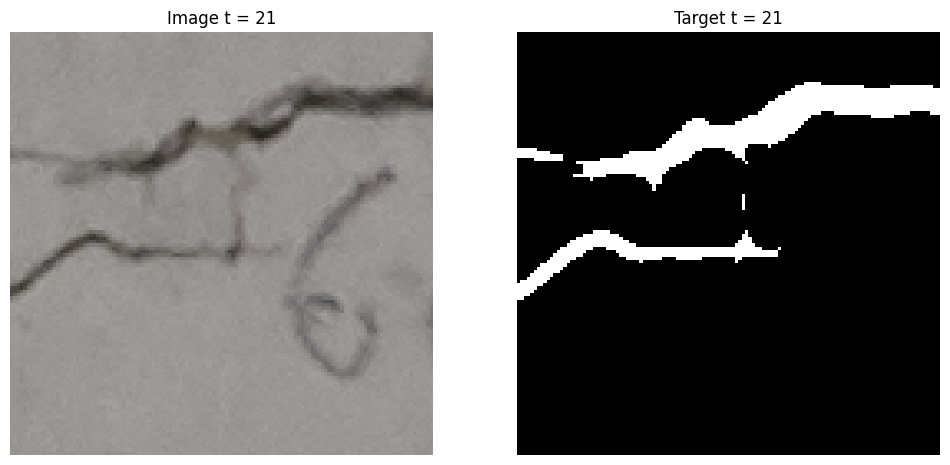

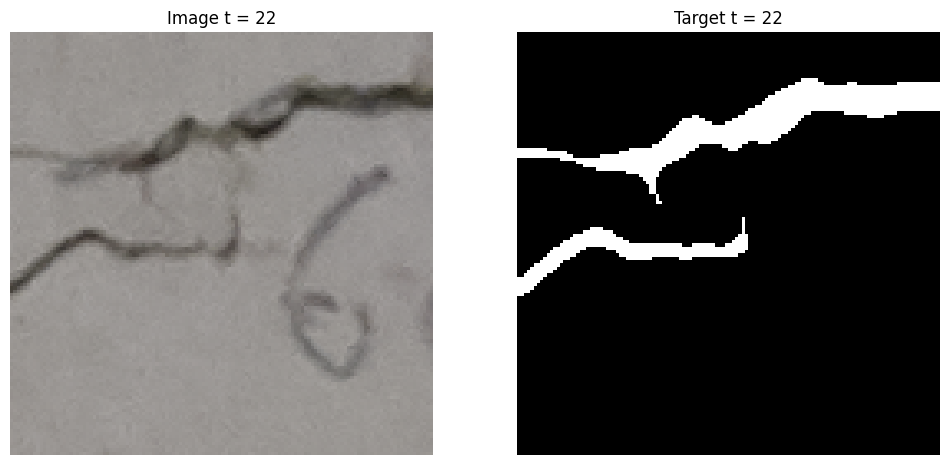

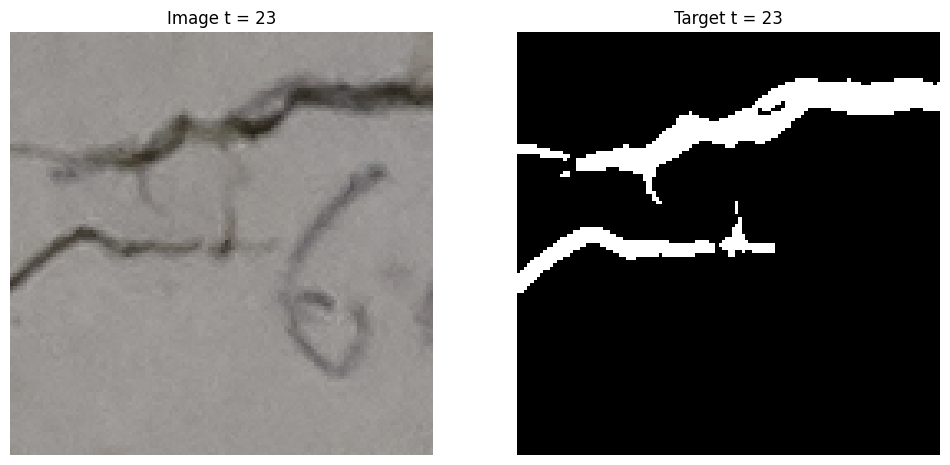

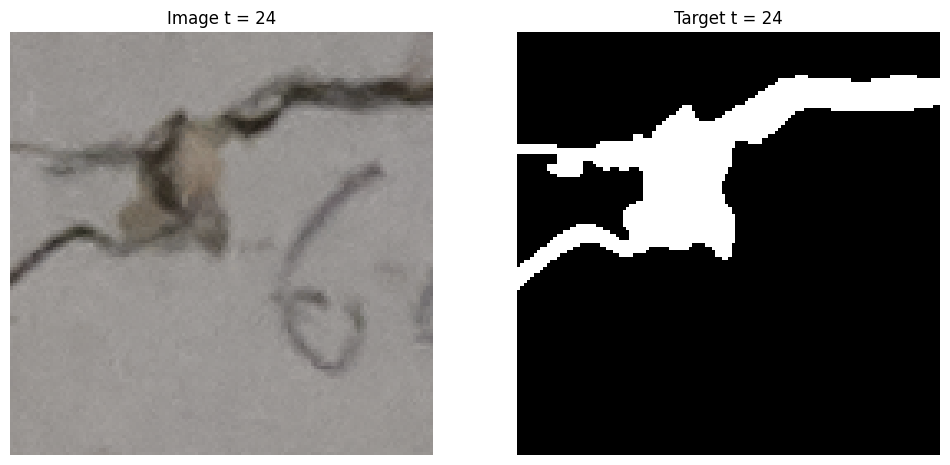

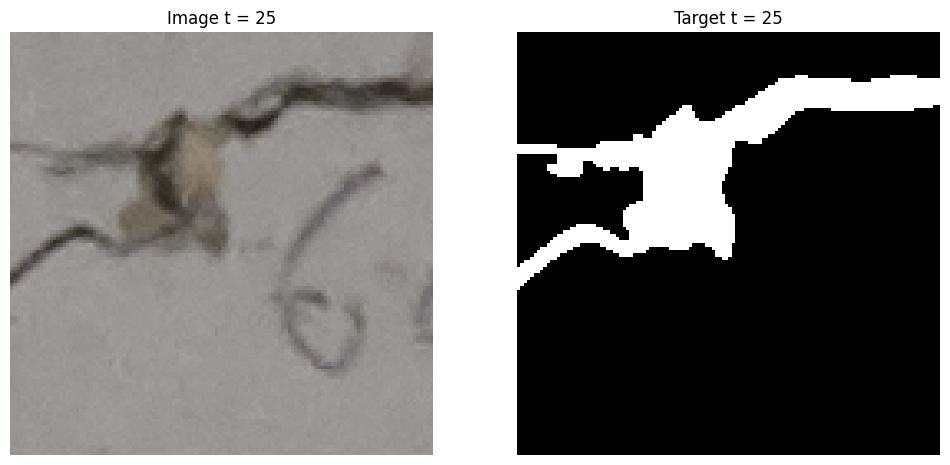

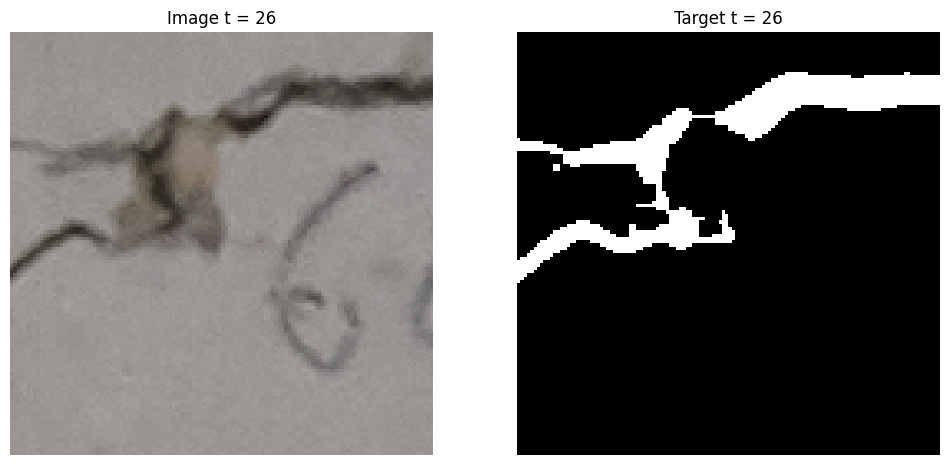

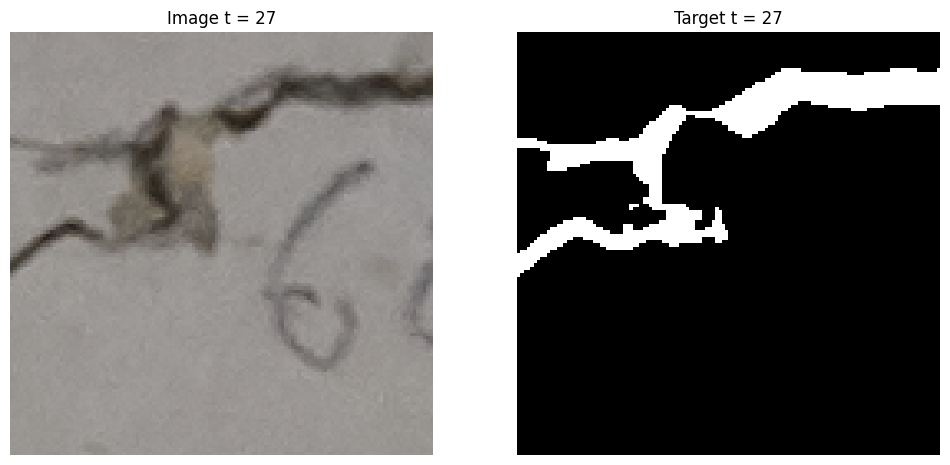

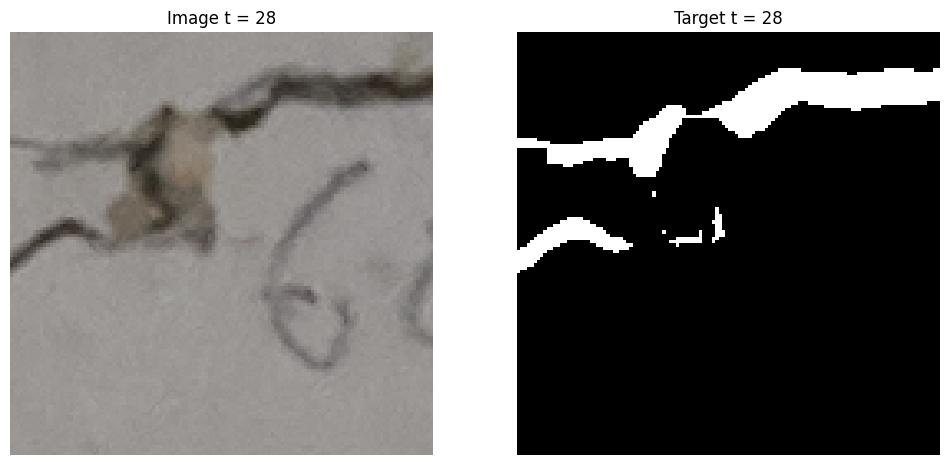

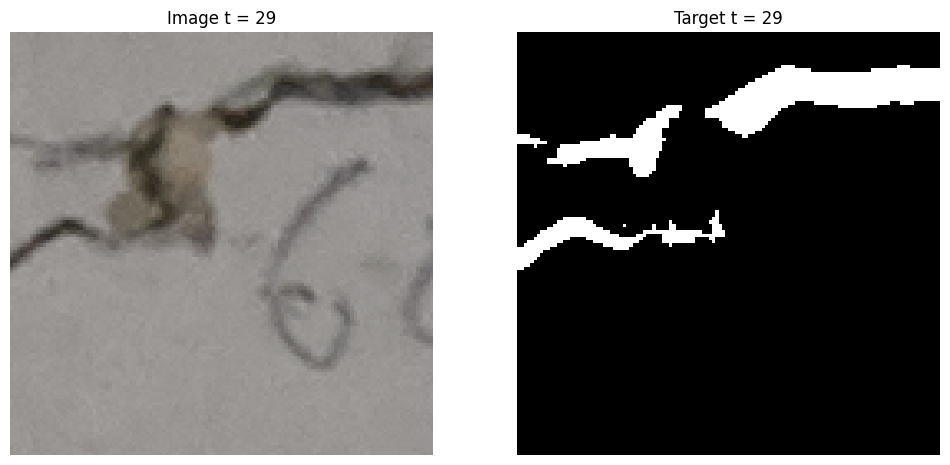

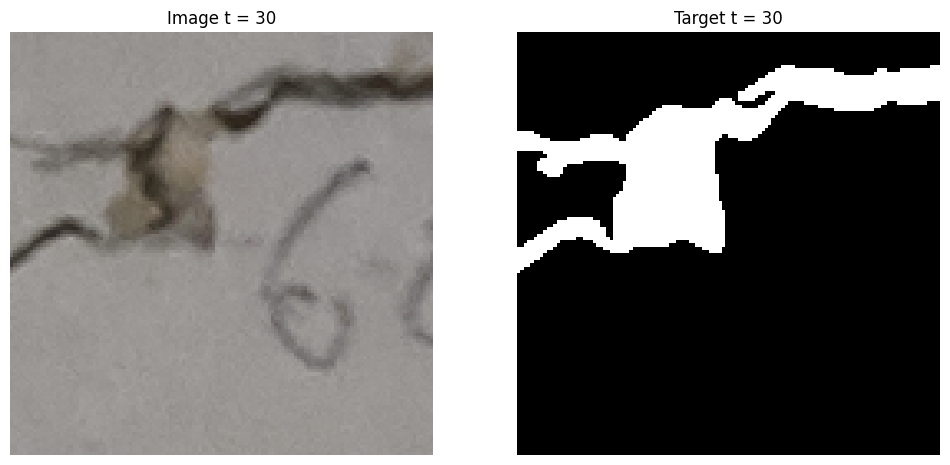

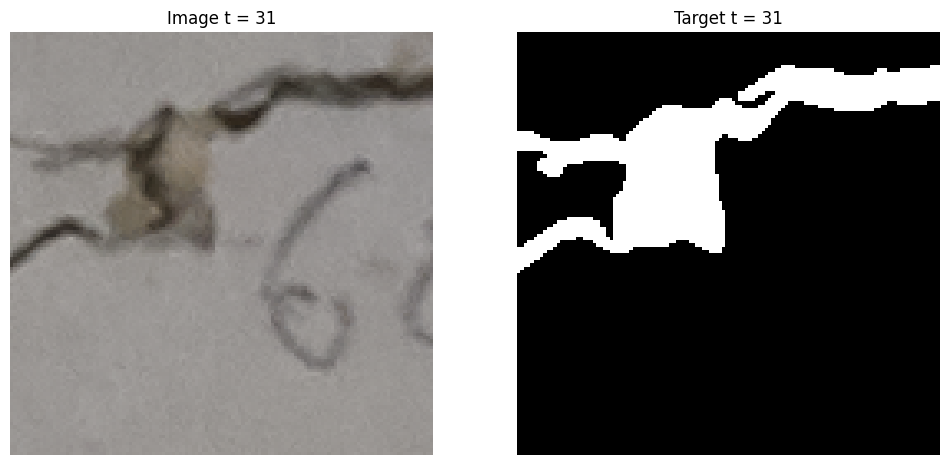

In [18]:
mt_dataset.visualize(1239) #1239, 2114, 4037